In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from methods import *  # methods.py must be in the same directory for this to work

## Problem 1: NMF
My row is duplicated (last one).
### Select complete submatrix

In [2]:
# Read in data and get complete rows/cols
raw = pd.read_csv('../data/MovieRankings36.csv', header=None).values

fullrows = np.ones((raw.shape[0],), dtype=bool)
goodcols = np.ones((raw.shape[1],), dtype=bool)
goodparam = int(raw.shape[0])/5  # number of entries need to be filled for a good col

# Count which cols are good
goodcols = (np.isnan(raw).sum(axis=0) >= goodparam).nonzero()
goodcols = goodcols[0]

# Count which rows are full in good columns
for i in range(raw[:, goodcols].shape[0]):
    if np.any(np.isnan(raw[i, goodcols])):
        fullrows[i] = False

In [3]:
# Select only full rows from raw to form the data matrix
# (only people who have seen all the movies)
# Also, set solver parameters and number of clusters
A = raw[fullrows, :]
A = A[:, goodcols]
k = 3  # number of clusters
maxiter = 1000
alpha = 0.01

### K-means clustering

In [4]:
# Changes every time you run it due to random initialization
L, R = kmeans(A, k, tol=1e-10)
print(L.nonzero()[1])

[2 2 2 2 0 2 1 2]


### Projected gradient descent

In [5]:
pgdW, pgdH, pgdnorms = pGD(A, k, alpha=alpha, maxiter=maxiter)

### Lee-Seung scheme

In [6]:
lsW, lsH, lsnorms = lee_seung(A, k, maxiter=maxiter)

### Projected gradient descent, then Lee-Seung

In [7]:
blendnorms = np.zeros((maxiter,))
s1 = int(maxiter/5)
s2 = maxiter - s1
blendW, blendH, blendnorms[:s1] = pGD(A, k, alpha=alpha, maxiter=s1)
blendW, blendH, blendnorms[s1:] = lee_seung(blendW @ blendH, k, maxiter=s2)

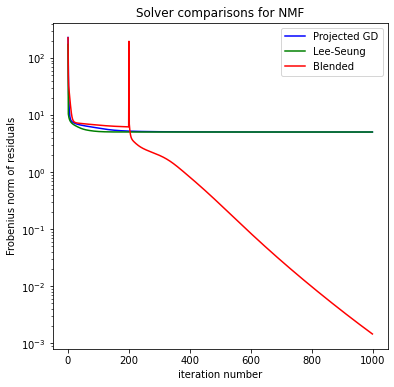

In [8]:
# Plot results
iternums = list(range(maxiter))

_ = plt.subplots(figsize=(6,6))
plt.semilogy(iternums, pgdnorms, '-b', iternums, lsnorms, '-g', iternums, blendnorms, '-r')
plt.xlabel('iteration number')
plt.ylabel('Frobenius norm of residuals')
plt.title('Solver comparisons for NMF')
plt.legend(['Projected GD', 'Lee-Seung', 'Blended'])
plt.savefig('nmf.png')
plt.show()

In [28]:
# Experiment with the split value
splits = np.linspace(0, 1, num=51)
endnorms = np.zeros(splits.shape)
avgiters = 10

for i in range(len(splits)):
    for _ in range(avgiters):
        s1 = int(splits[i] * maxiter)
        if s1 >= 1000: s1 = 999
        elif s1 <= 1:  s1 = 1
        
        s2 = maxiter - s1
        blendW, blendH, _ = pGD(A, k, alpha=alpha, maxiter=s1)
        _, _, norms = lee_seung(blendW @ blendH, k, maxiter=s2)
        endnorms[i] += norms[-1]/avgiters
    
    if i % 10 == 0:
        print(f'percentage {splits[i]*100} completed')

percentage 0.0 completed
percentage 20.0 completed
percentage 40.0 completed
percentage 60.0 completed
percentage 80.0 completed
percentage 100.0 completed


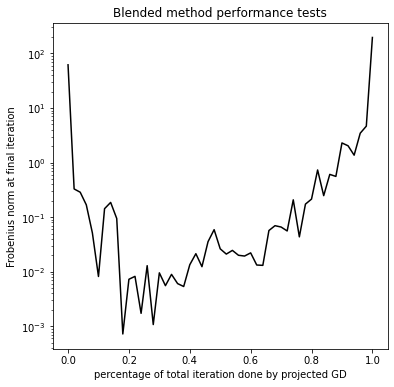

In [29]:
_ = plt.subplots(figsize=(6,6))
plt.semilogy(splits, endnorms, '-k')
plt.xlabel('percentage of total iteration done by projected GD')
plt.ylabel('Frobenius norm at final iteration')
plt.title('Blended method performance tests')
plt.savefig('blended_endtime.png')
plt.show()

## Problem 2: Matrix completion
### Low-rank factorization

In [2]:
# Reassign A to be the raw data
A = pd.read_csv('../data/MovieRankings36.csv', header=None).values
maxiters, k = 1000, 3

In [3]:
Mlr = low_rank(A, k, maxiter=maxiters)

In [4]:
Mnn = nuclear_norm(A, maxiter=maxiters)

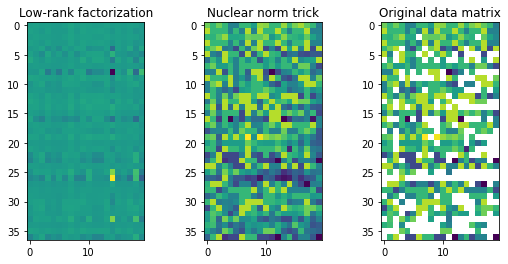

In [5]:
_, (ax1, ax2, ax3) = plt.subplots(figsize=(9,4), ncols=3)
ax1.imshow(Mlr)
ax1.set_title('Low-rank factorization')  # low-rank factorization method is not perfect

ax2.imshow(Mnn)
ax2.set_title('Nuclear norm trick')

ax3.imshow(A)
ax3.set_title('Original data matrix')
plt.show()